In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
import pandas as pd
import numpy as np
from typing import Optional, List, Callable, Any, Union, Dict
from itertools import product
from statistics import mean
from pathlib import Path
import gzip
import os
import matplotlib.pyplot as plt

### Read datasets
Use the gzip function is files ar gzipped

In [3]:
def read_ds_gzip(path: Optional[Path]=None, ds: str = "TEST") -> pd.DataFrame:
    """Args:
        path (Optional[Path], optional): the path to read the dataset file. Defaults to /kaggle/input/the-insa-starcraft-2-player-prediction-challenge/{ds}.CSV.gz.
        ds (str, optional): the part to read (TEST or TEST), to use when path is None. Defaults to "TEST".

    Returns:
        pd.DataFrame:
    """
    with gzip.open(f'/kaggle/input/the-insa-starcraft-2-player-prediction-challenge/{ds}.CSV.gz' if path is None else path) as f:
        max_actions = max(( len( str(c).split(",")) for c in f.readlines() ))
        f.seek(0)
        _names = ["battleneturl", "played_race"] if "TRAIN" in ds else ["played_race"]
        _names.extend(range(max_actions - len(_names)))
        return pd.read_csv(f, names=_names, dtype= str)

def read_ds(path: Optional[Path]=None, ds: str = "TEST"):
    """Args:
        path (Optional[Path], optional): the path to read the dataset file. Defaults to /kaggle/input/the-insa-starcraft-2-player-prediction-challenge/{ds}.CSV.gz.
        ds (str, optional): the part to read (TEST or TEST), to use when path is None. Defaults to "TEST".

    Returns:
        pd.DataFrame:
    """
    with open(f'/kaggle/input/test-sc2-keystrokes/{ds}.CSV' if path is None else path) as f:
        max_actions = max(( len( str(c).split(",")) for c in f.readlines() ))
        f.seek(0)
        _names = ["battleneturl", "played_race"] if "TEST" in ds else ["played_race"]
        _names.extend(range(max_actions - len(_names)))
        return pd.read_csv(f, names=_names, dtype= str)

In [4]:
train = read_ds_gzip(Path("data/TRAIN.CSV.GZ"), ds="TRAIN") # Replace with correct path 

In [40]:
train.describe()

,battlenetcode
count,3052.000000
mean,92.497051
std,54.056482
min,0.000000
25%,49.000000
50%,91.500000
75%,131.000000
max,199.000000


In [6]:
def to_categories(df: pd.DataFrame, col: str="battleneturl") -> None:
    """Convert col of df to a categorical column"""
    df["battleneturl"] = pd.Categorical(df["battleneturl"])
    df["battlenetcode"] = df[[col]].apply(lambda x: x.cat.codes)


In [7]:
url_dict = to_categories(train)
train.head()

,battleneturl,played_race,0,1,2,3,4,5,6,7,...,10528,10529,10530,10531,10532,10533,10534,10535,10536,battlenetcode
0,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,Base,s,s,s,s,s,t5,Base,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53
1,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,s,Base,s,s,Base,s,s,Base,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29
2,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,Base,s,s,s,Base,s,hotkey30,hotkey00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53
3,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,Base,s,s,Base,s,s,s,t5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29
4,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,Base,s,s,s,Base,s,hotkey30,hotkey00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53


In [8]:
url_dict = {row['battlenetcode']: row['battleneturl'] for _, row in train.iterrows()}
url_dict

{53: 'http://eu.battle.net/sc2/en/profile/4234852/1/First/',
 29: 'http://eu.battle.net/sc2/en/profile/3074362/1/Stardust/',
 35: 'http://eu.battle.net/sc2/en/profile/3401218/1/Welmu/',
 24: 'http://eu.battle.net/sc2/en/profile/2896854/1/MǂForGG/',
 40: 'http://eu.battle.net/sc2/en/profile/3538115/1/Golden/',
 17: 'http://eu.battle.net/sc2/en/profile/250458/1/VortiX/',
 49: 'http://eu.battle.net/sc2/en/profile/3973341/1/yoeFWSan/',
 16: 'http://eu.battle.net/sc2/en/profile/2452136/1/MinChul/',
 11: 'http://eu.battle.net/sc2/en/profile/2222468/1/dTefel/',
 54: 'http://eu.battle.net/sc2/en/profile/4341883/1/Patience/',
 61: 'http://eu.battle.net/sc2/en/profile/950504/1/Grubby/',
 25: 'http://eu.battle.net/sc2/en/profile/2898004/1/MMA/',
 18: 'http://eu.battle.net/sc2/en/profile/251061/1/LiveZerg/',
 0: 'http://eu.battle.net/sc2/en/profile/1021189/1/Dayshi/',
 32: 'http://eu.battle.net/sc2/en/profile/326029/1/LiquidTLO/',
 2: 'http://eu.battle.net/sc2/en/profile/1058669/1/Happy/',
 3: 'ht

In [57]:
features_test = read_ds_gzip(Path("data/TEST.CSV.GZ")) # Replace with correct path 

# features_test = read_ds("TEST")
features_test.shape #, features_test.shape

(340, 6818)

In [58]:
features_test.shape

(340, 6818)

### Dependent Variable
Our dependent variable is a categorical string; we can convert it to categories codes (number) with pd.Categorical

pd.Categorical doesn't directly modify the battleneturl to a number, instead it adds a cat.codes attribute to it. We can create a little function to convert the dependent variable from string to its category ID:

#### Removing outliers
YOUR IDEAS / APPROACHES HERE.



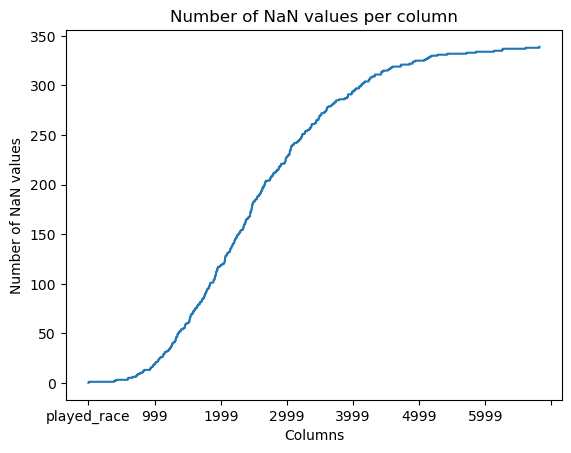

In [12]:
import matplotlib.pyplot as plt

nan_counts = features_test.isna().sum()
nan_counts.plot()
plt.xlabel('Columns')
plt.ylabel('Number of NaN values')
plt.title('Number of NaN values per column')
plt.show()

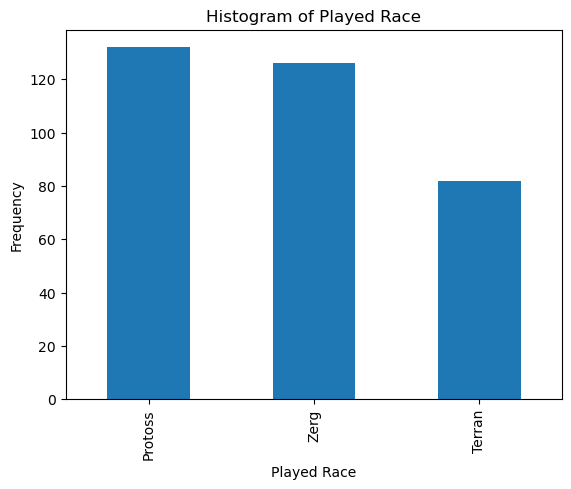

In [13]:
features_test['played_race'].value_counts().plot(kind='bar')
plt.xlabel('Played Race')
plt.ylabel('Frequency')
plt.title('Histogram of Played Race')
plt.show()

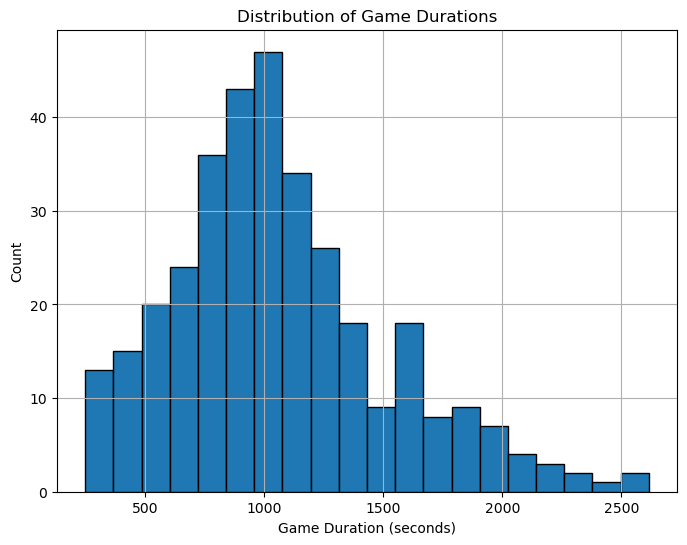

In [14]:

durations = []

# Iterate over each row in the dataframe
for _, row in features_test.iterrows():
    # Convert the row to a list (strings, possibly some NaN if missing)
    row_list = row.tolist()

    # Filter columns that start with "t" (e.g., "t10", "t120", etc.)
    time_tokens = [
        col for col in row_list if isinstance(col, str) and col.startswith("t")
    ]

    if time_tokens:
        # Get the last time token in the row
        last_time_token = time_tokens[-1]
        # Convert from e.g. "t135" -> integer 135
        duration = int(last_time_token[1:])
        durations.append(duration)
    else:
        # If no time tokens, we can append None or skip.
        durations.append(None)

# Store the durations in the dataframe as a new column for convenience
features_test["duration"] = durations

# Drop rows without a valid duration
features_test.dropna(subset=["duration"], inplace=True)

# Plot the distribution as a histogram
plt.figure(figsize=(8, 6))
features_test["duration"].plot(kind="hist", bins=20, edgecolor="black")
plt.title("Distribution of Game Durations")
plt.xlabel("Game Duration (seconds)")
plt.ylabel("Count")
plt.grid(True)
plt.show()


In [63]:
# # Keep the central 96% (remove bottom and top 2%)
# q02 = features_test['duration'].quantile(0.02)
# q98 = features_test['duration'].quantile(0.98)

# features_test_filtered = features_test[(features_test['duration'] >= q02) & (features_test['duration'] <= q98)]
    

# # Plot the distribution as a histogram
# plt.figure(figsize=(8, 6))
# features_test_filtered['duration'].plot(kind='hist', bins=20, edgecolor='black')
# plt.title('Distribution of Game Durations')
# plt.xlabel('Game Duration (seconds)')
# plt.ylabel('Count')
# plt.grid(True)
# plt.show()
features_test_filtered = features_test

In [59]:
import pandas as pd

# Display global statistics about the dataset
print("Total number of rows (games):", len(features_test_filtered))

# If you have a unique player identifier (e.g. 'battleneturl')
if "battleneturl" in features_test_filtered.columns:
    print("Number of unique players:", features_test_filtered["battleneturl"].nunique())

# If you have a race column (e.g. 'played_race')
if "played_race" in features_test_filtered.columns:
    print("Number of unique races:", features_test_filtered["played_race"].nunique(), "\n")
    print("=== Race Distribution ===\n", features_test_filtered["played_race"].value_counts(), "\n")

# Basic statistics for durations
if "duration" in features_test_filtered.columns:
    print("=== Duration Summary ===")
    print(features_test_filtered["duration"].agg(["min", "max", "mean", "std"]))

    # Example: Group by race to see duration stats per race
    if "played_race" in features_test_filtered.columns:
        print("\n=== Duration by Race ===")
        print(features_test_filtered.groupby("played_race")["duration"].agg(["min", "max", "mean", "std"]))


Total number of rows (games): 339
Number of unique races: 3 

=== Race Distribution ===
 played_race
Protoss    131
Zerg       126
Terran      82
Name: count, dtype: int64 



In [41]:
# drop duration column
features_test_filtered.drop(columns=['duration'], inplace=True)

In [64]:
# Make a deep copy to avoid the SettingWithCopyWarning
features_test_filtered = features_test_filtered.copy()

# Now safely do your assignments
action_cols = features_test_filtered.columns[2:]
features_test_filtered["actions"] = (
    features_test_filtered[action_cols]
    .apply(lambda row: [x for x in row if pd.notna(x)], axis=1)
)

features_test_filtered.drop(columns=action_cols, inplace=True)

### Custom features

In [65]:
def chunkify_actions(action_list):
    """
    Given a list of actions (e.g., ["Base", "s", "s", "t5", "hotkey30", "t10", ...]),
    produce a list of tuples (start_time, end_time, actions_in_chunk).
    If we see 't5', that means the chunk boundary is 5 seconds, etc.
    """
    chunks = []
    current_time = 0
    chunk_actions = []

    def parse_time_marker(a):
        # e.g. 't5' -> int("5")
        return int(a[1:])

    for a in action_list:
        if a.startswith("t"):
            # We hit a time boundary
            end_time = parse_time_marker(a)
            if chunk_actions:
                chunks.append((current_time, end_time, chunk_actions))
            # Move forward
            current_time = end_time
            chunk_actions = []
        else:
            # It's a normal action
            chunk_actions.append(a)

    # If leftover actions exist after the last tXX
    # We'll treat them as from current_time to current_time (0-length),
    # or you can define a “max game time” if known. For now, let's store them anyway.
    if chunk_actions:
        chunks.append((current_time, current_time, chunk_actions))

    return chunks


In [66]:
def compute_features_per_chunk(chunks):
    """
    Given a list of (start_t, end_t, actions_in_chunk),
    classify them into early/mid/late, count relevant actions,
    compute average in each phase.
    """
    # Phase boundaries
    EARLY_MAX = 360  # 6 minutes
    MID_MAX = 720  # 12 minutes

    # We'll accumulate total counts and total durations (in seconds) for each phase
    phases = ["early", "mid", "late"]

    base_keys = {
        "hk_created": 0,
        "hk_updated": 0,
        "hk_used":    0,
        "base":       0,
        "mineral":    0,
        "other":      0
    }

    phase_counts = {
        ph: {
            **{f"hk_{i}": 0 for i in range(10)},
            **base_keys
        }
        for ph in phases
    }

    phase_durations = {ph: 0 for ph in phases}

    def get_phase(t):
        if t < EARLY_MAX:
            return "early"
        elif t < MID_MAX:
            return "mid"
        else:
            return "late"

    for start_t, end_t, acts in chunks:
        # Simple approach: classify chunk by its start time (some people use midpoint)
        phase = get_phase(start_t)
        # Avoid zero durations => set it to at least 1 second
        duration = max(1, end_t - start_t)

        # Count actions in this chunk
        c_hk_pressed = {f"c_hk_{i}": 0 for i in range(10)}
        c_hk_created = 0
        c_hk_updated = 0
        c_hk_used = 0
        c_base = 0
        c_mineral = 0
        c_other = 0

        for a in acts:
            if a.startswith("hotkey"):
                key = int(a[-2])
                c_hk_pressed[f"c_hk_{key}"] += 1
                # check last char if it is "0","1","2"
                if a.endswith("0"):
                    c_hk_created += 1
                elif a.endswith("1"):
                    c_hk_updated += 1
                elif a.endswith("2"):
                    c_hk_used += 1
            elif a in ["sBase", "Base"]:
                c_base += 1
            elif a in ["sMineral", "SingleMineral"]:
                c_mineral += 1
            elif a == "s":
                c_other += 1
            else:
                # some other action not relevant here
                pass

        for i in range(10):
            phase_counts[phase][f"hk_{i}"] += c_hk_pressed[f"c_hk_{i}"]
        phase_counts[phase]["hk_created"] += c_hk_created
        phase_counts[phase]["hk_updated"] += c_hk_updated
        phase_counts[phase]["hk_used"] += c_hk_used
        phase_counts[phase]["base"] += c_base
        phase_counts[phase]["mineral"] += c_mineral
        phase_counts[phase]["other"] += c_other

        phase_durations[phase] += duration

    # Now compute the final average for each phase
    # e.g.  (count / total_duration_in_phase)
    feats = {}
    for phase in ["early", "mid", "late"]:
        dur = phase_durations[phase]
        pc = phase_counts[phase]
        if dur == 0:
            # no data for that phase
            for i in range(10):
                feats[f"{phase}_hotkey_{i}"] = 0
            feats[f"{phase}_hotkey_created"] = 0
            feats[f"{phase}_hotkey_updated"] = 0
            feats[f"{phase}_hotkey_used"] = 0
            feats[f"{phase}_base"] = 0
            feats[f"{phase}_mineral"] = 0
            feats[f"{phase}_other"] = 0
        else:
            for i in range(10):
                feats[f"{phase}_hotkey_{i}"] = (pc[f"hk_{i}"] / dur)
            feats[f"{phase}_hotkey_created"] = (pc["hk_created"] / dur)
            feats[f"{phase}_hotkey_updated"] = (pc["hk_updated"] / dur)
            feats[f"{phase}_hotkey_used"] = (pc["hk_used"] / dur)
            feats[f"{phase}_base"] = (pc["base"] / dur)
            feats[f"{phase}_mineral"] = (pc["mineral"] / dur)
            feats[f"{phase}_other"] = (pc["other"] / dur)

    return feats

In [67]:
def compute_all_features(row):
    """
    row is a single Pandas row with:
       row["actions"] = list of action strings
       row["battleneturl"], row["played_race"], etc. if needed
    Returns a dict of feature_name -> value
    """
    chunks = chunkify_actions(row)
    feats = compute_features_per_chunk(chunks)
    
    # You can also include the player's ID or race in the returned features if desired
    return feats

# Apply to entire DataFrame
features_df = features_test_filtered["actions"].apply(compute_all_features).apply(pd.Series)

print(features_df.head())

# Combine with the original df if you like
result_df = pd.concat([features_test_filtered, features_df], axis=1)
print(result_df.head())


   early_hotkey_0  early_hotkey_1  early_hotkey_2  early_hotkey_3  \
0        1.239437        0.267606        0.047887        0.011268   
1        0.011429        0.577143        0.188571        0.874286   
2        0.000000        0.333333        0.463889        0.358333   
3        0.000000        0.331343        0.250746        0.002985   
4        0.005714        0.048571        0.074286        0.017143   

   early_hotkey_4  early_hotkey_5  early_hotkey_6  early_hotkey_7  \
0        0.000000        0.000000        1.391549        0.019718   
1        0.877143        0.000000        0.000000        0.000000   
2        0.161111        0.000000        1.419444        0.013889   
3        0.447761        0.000000        0.000000        0.000000   
4        0.031429        0.211429        0.000000        0.005714   

   early_hotkey_8  early_hotkey_9  ...  late_hotkey_6  late_hotkey_7  \
0        0.000000        0.047887  ...       0.858974       0.019231   
1        0.000000        0

In [69]:
features_df["race"] = features_test_filtered["played_race"]

In [70]:
print(features_df.head())
copy_df = features_df.copy()

   early_hotkey_0  early_hotkey_1  early_hotkey_2  early_hotkey_3  \
0        1.239437        0.267606        0.047887        0.011268   
1        0.011429        0.577143        0.188571        0.874286   
2        0.000000        0.333333        0.463889        0.358333   
3        0.000000        0.331343        0.250746        0.002985   
4        0.005714        0.048571        0.074286        0.017143   

   early_hotkey_4  early_hotkey_5  early_hotkey_6  early_hotkey_7  \
0        0.000000        0.000000        1.391549        0.019718   
1        0.877143        0.000000        0.000000        0.000000   
2        0.161111        0.000000        1.419444        0.013889   
3        0.447761        0.000000        0.000000        0.000000   
4        0.031429        0.211429        0.000000        0.005714   

   early_hotkey_8  early_hotkey_9  ...  late_hotkey_7  late_hotkey_8  \
0        0.000000        0.047887  ...       0.019231       0.000000   
1        0.000000        0

### Getting features...

Building a mini framework to read our Dataframe and convert it to features.

Now we will create features out of the dataset.

FeaturesGetter iterates over an ActionsDataLoader (yield every actions between two 't[xx]') and apply a set of Feature contained in a FeaturePool. At the end, it gets metrics over the values registered by each features in the feature pool.

Defining lambdas to convert dataset to features
We create basic features, corresponding to the mean of each action played per timestamp plus the mean of all actions together

Now it's ready to be put into a function that'll get all the features from the initial dataframe and return a new dataframe containing only those features. FeaturesGetter gets one extra feature from that we created, which is max_time, corresponding to the "xx" of the last "txx" seen.

### Handling string
The race_played column can only take three values; instead of converting it to categorical as we did with our dependent variable, we will instead convert it to dummy variables: we one-hot encode each race. It will not add many columns to our dataframe (only three) but will allow the decision trees to split much faster on the race (on only one binary split).

In [71]:
def get_dummies(df: pd.DataFrame):
    """Converts textual columns to one-hot encoded vectors (one column per possible value)"""
    df = pd.get_dummies(df, columns=["race"])
    return df

Function preprocess creates a pipeline of all the function we just implemented: it create the features, converts the race to dummy variables and the dependent variable to category codes.

In [72]:
features_df = get_dummies(features_df)

In [74]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 51 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   early_hotkey_0        340 non-null    float64
 1   early_hotkey_1        340 non-null    float64
 2   early_hotkey_2        340 non-null    float64
 3   early_hotkey_3        340 non-null    float64
 4   early_hotkey_4        340 non-null    float64
 5   early_hotkey_5        340 non-null    float64
 6   early_hotkey_6        340 non-null    float64
 7   early_hotkey_7        340 non-null    float64
 8   early_hotkey_8        340 non-null    float64
 9   early_hotkey_9        340 non-null    float64
 10  early_hotkey_created  340 non-null    float64
 11  early_hotkey_updated  340 non-null    float64
 12  early_hotkey_used     340 non-null    float64
 13  early_base            340 non-null    float64
 14  early_mineral         340 non-null    float64
 15  early_other           3

## ML !!!

In [75]:
# Load the random forest model saved with jovlib (sklearn) from disk
filename = 'random_forest_model.pkl'
loaded_model = pickle.load(open(filename, 'rb'))

In [76]:
pred = loaded_model.predict(features_df)

In [78]:
pred.shape

(340,)

In [79]:
# Convert the array of codes to URLs using the url_dict
urls = [url_dict[code] for code in pred]

# Create a new DataFrame with these URLs
urls_df = pd.DataFrame(urls, columns=['prediction'])

# Add a 'RowId' column starting at index 1
urls_df['RowId'] = range(1, len(urls_df) + 1)

# Set 'RowId' as the index
urls_df.set_index('RowId', inplace=True)

# Display the new DataFrame
print(urls_df.head())

                                              prediction
RowId                                                   
1      http://eu.battle.net/sc2/en/profile/3538115/1/...
2      http://eu.battle.net/sc2/en/profile/2896854/1/...
3      http://eu.battle.net/sc2/en/profile/3973341/1/...
4      http://eu.battle.net/sc2/en/profile/250458/1/V...
5      http://eu.battle.net/sc2/en/profile/950504/1/G...


In [80]:
print(pred.shape)

(340,)


In [81]:
# to csv
urls_df.to_csv('submission.csv')